In [508]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [509]:
sns.set("notebook", style="white")

In [510]:
delta_t = 2
x_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
x_plot = np.linspace(-2, 2, 1000)

In [511]:
def height(x):
    
    if x <= 0:
        y = x**2 + x + 0.25
    else:
        y = x*(1+5*x**2)**(-1/2) + (1/32)*(x**4) + 0.25
    
    return y

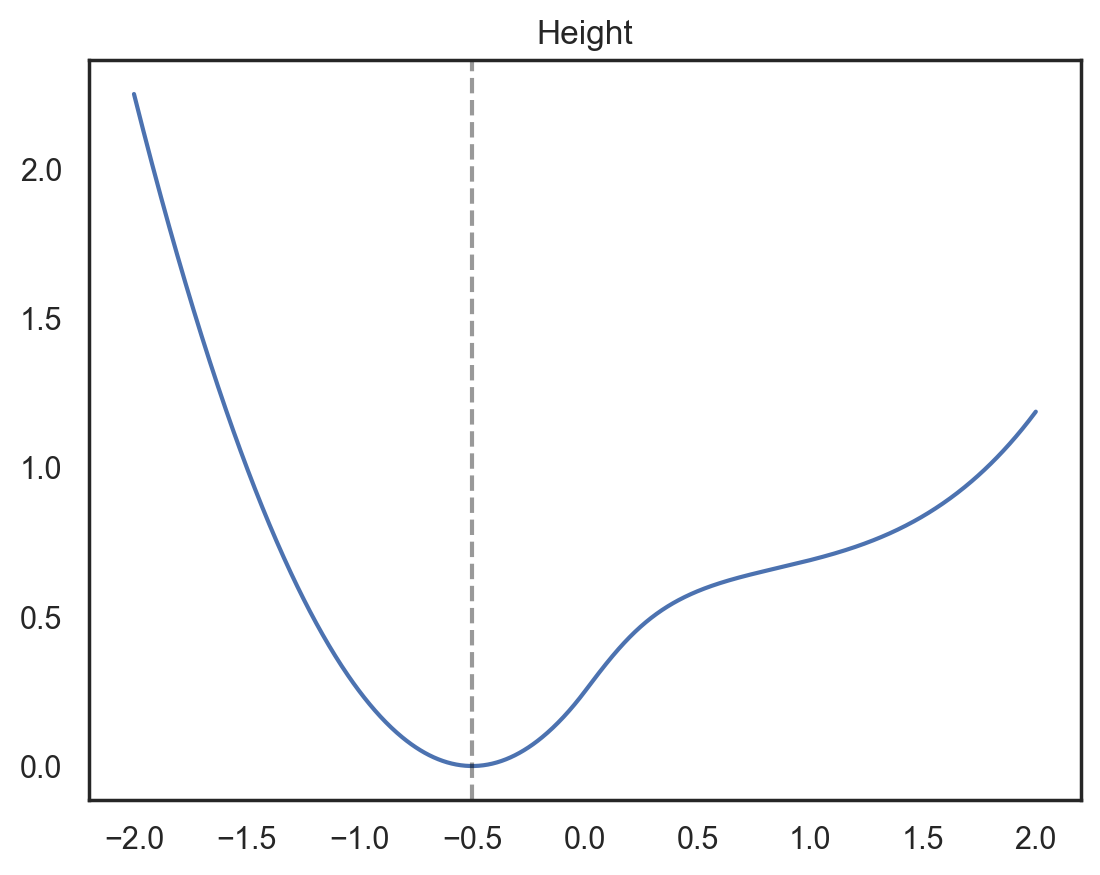

In [512]:
fig, ax = plt.subplots()
ax.plot(x_plot, [height(x) for x in x_plot])
ax.set_title("Height")
ax.axvline(-0.5, linestyle="--", color="black", alpha=0.4);

In [513]:
def phi(x):
    if x <= 0:
        return -2*x - 1
    else:
        return -(1+5*x**2)**(-3/2) - (1/8)*x**3

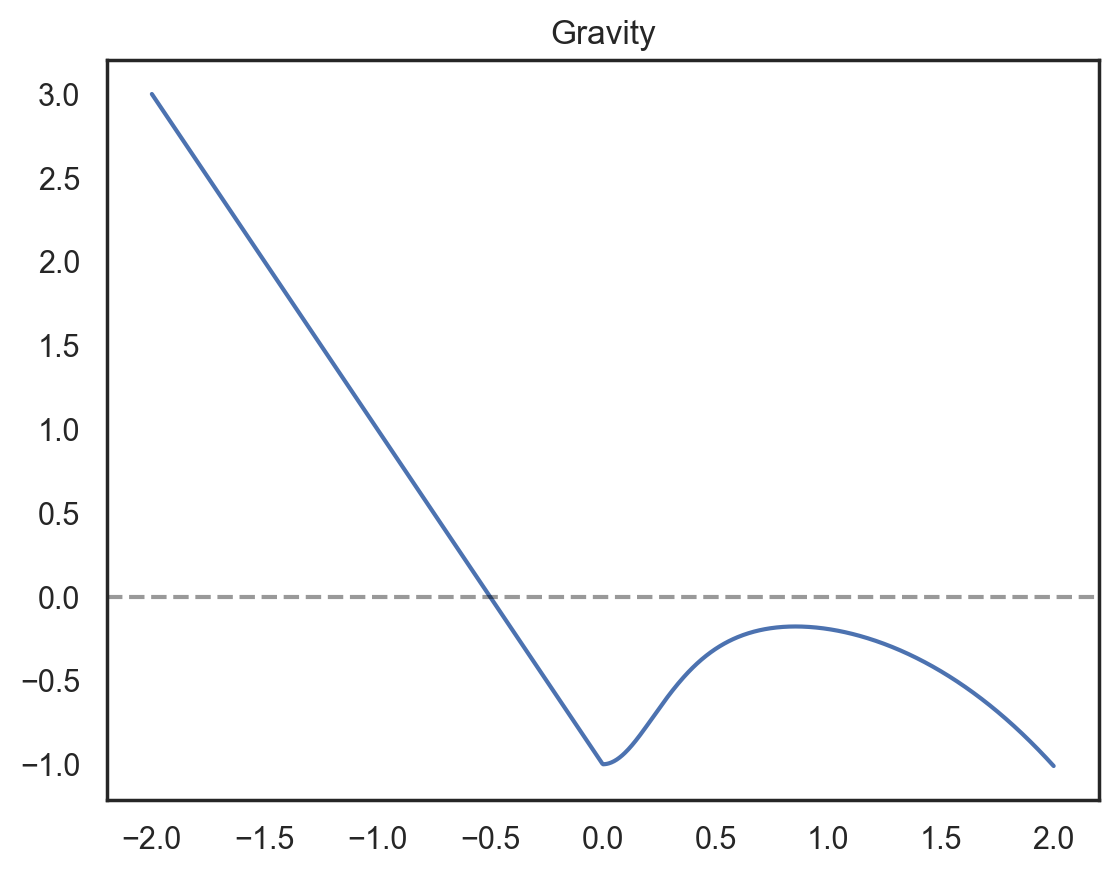

In [514]:
fig, ax = plt.subplots()
ax.plot(x_plot, [phi(x) for x in x_plot])
ax.axhline(0, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gravity");

In [515]:
actions = np.arange(-2, 3)
actions

array([-2, -1,  0,  1,  2])

In [516]:
def update_position_and_velocity(position, velocity, action):
    force_action = np.tanh(action)
    force_friction = -(1/8) * velocity
    force_gravity = phi(position)
    force = force_gravity + force_friction + force_action
    velocity += force
    position += velocity
    return position, velocity

In [10]:
position, velocity = (-2.0, 0.0)
update_position_and_velocity(position, velocity, 0)

(1.0, 3.0)

In [11]:
position, velocity = update_position_and_velocity(position, velocity, 2)
position, velocity

(1.964027580075817, 3.964027580075817)

## Gym

In [12]:
import gym

In [13]:
env = gym.make("MountainCar-v0")

In [14]:
env.reset()

array([-0.5384156,  0.       ], dtype=float32)

In [15]:
env.step(2)

(array([-0.5373045 ,  0.00111109], dtype=float32), -1.0, False, {})

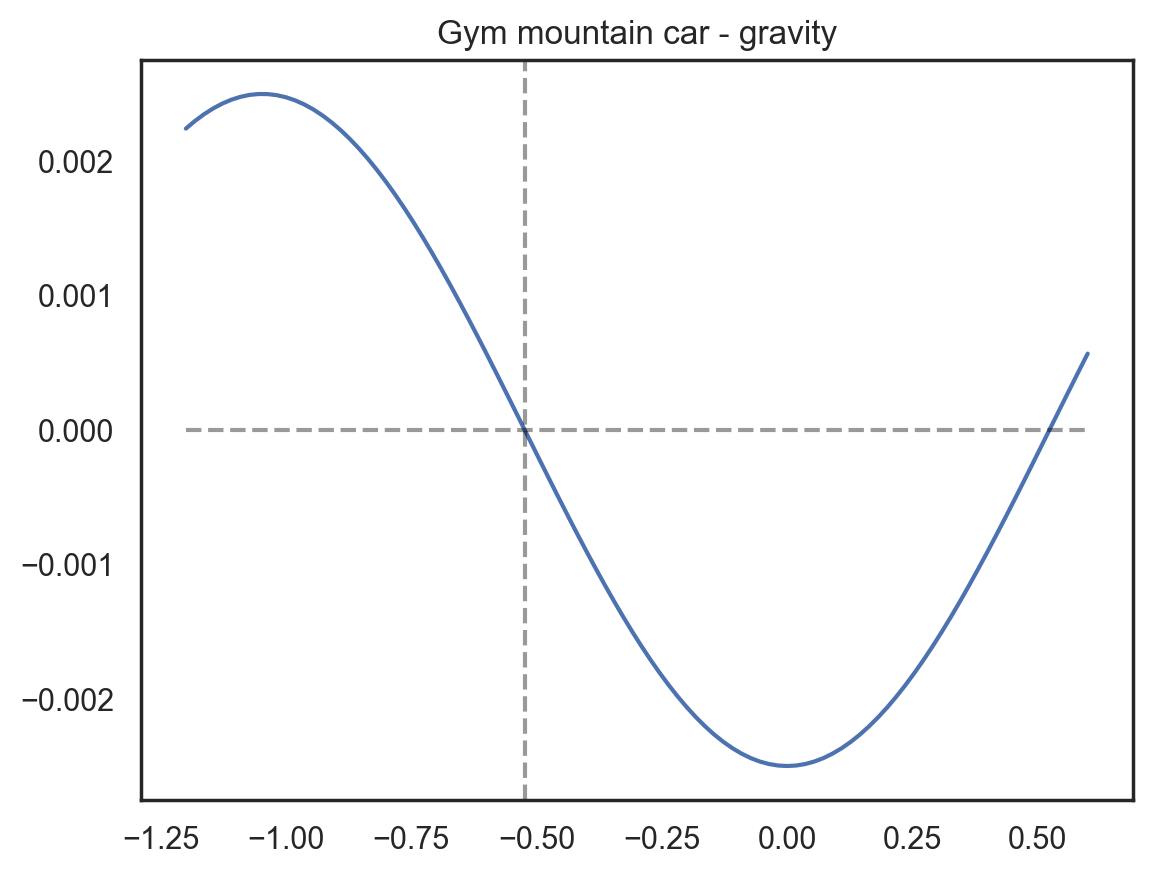

In [16]:
x_gym = np.linspace(-1.2, 0.6, 100)

fig, ax = plt.subplots()
ax.plot(x_gym, -0.0025 * np.cos(3*x_gym))
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.hlines(0., xmin=x_gym[0], xmax=x_gym[-1], linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - gravity");

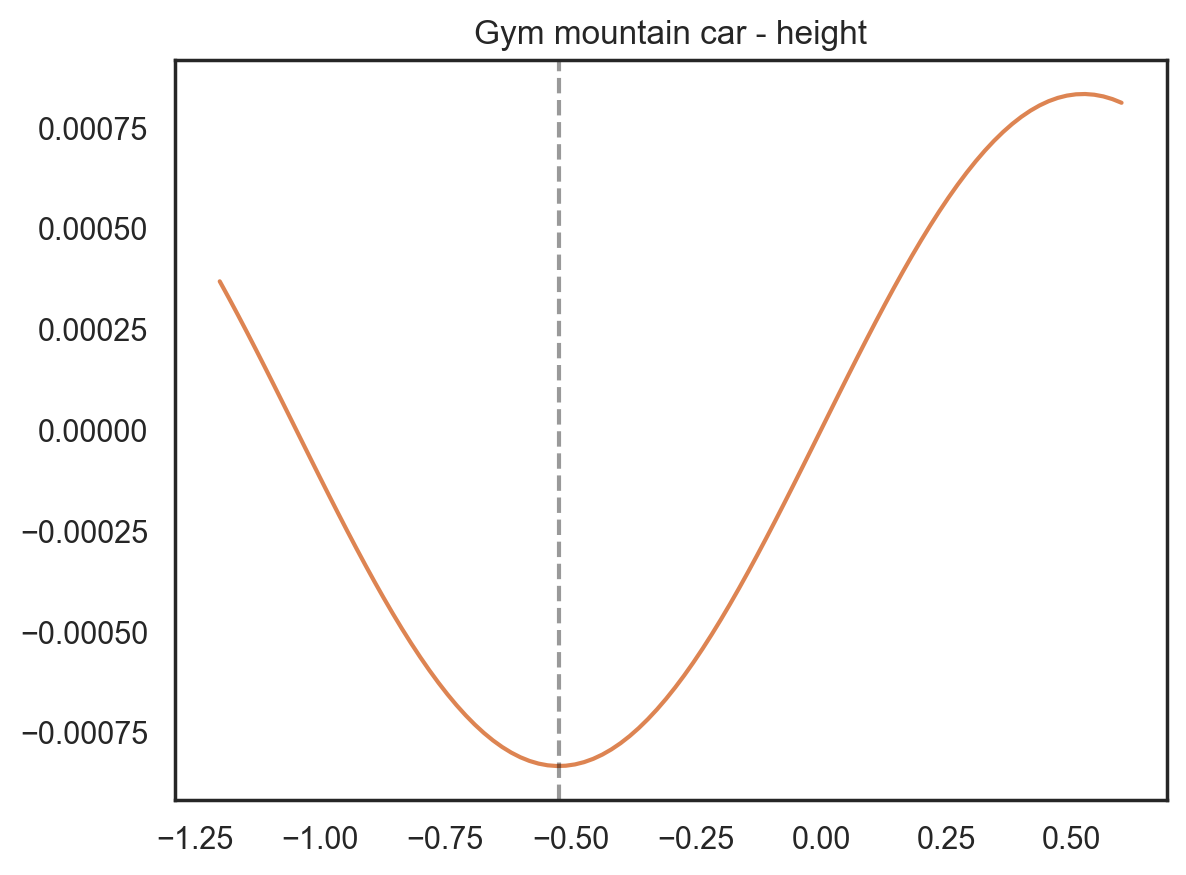

In [17]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200, color="C1")
ax.axvline(-np.pi/6, linestyle="--", color="black", alpha=0.4)
ax.set_title("Gym mountain car - height");

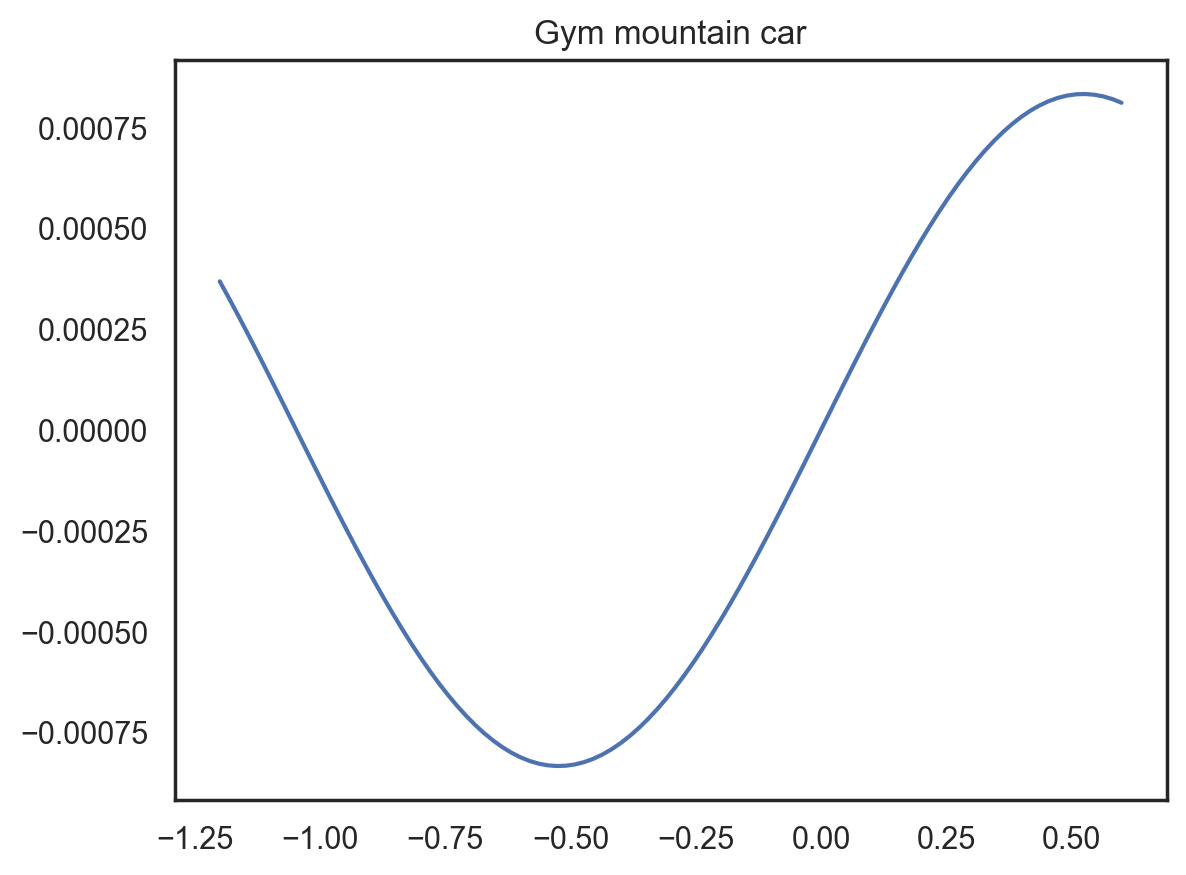

In [18]:
fig, ax = plt.subplots()
ax.plot(x_gym, np.sin(3*x_gym)/1200)
ax.set_title("Gym mountain car");

In [19]:
def dynamics_gym(position, velocity, action, gravity=0.0025, force=0.001):
    assert action in [-1, 0, 1], "Action needs to be either -1, 0, or 1"
    velocity += action*force - np.cos(3 * position) * gravity
    position += velocity
    return position, velocity

In [20]:
position, velocity = -np.pi/6, 0
actions = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 
for i, action in enumerate(actions):
    position, velocity = dynamics_gym(position, velocity, action)
    velocity = np.clip(velocity, -0.07, 0.07)
    position = np.clip(position, -1.2, 0.6)
    print(i, action, position, velocity)

0 1 -0.5225987755982988 0.0009999999999999998
1 1 -0.5206062755870489 0.0019925000112499943
2 1 -0.5176362190244069 0.0029700565626419734
3 1 -0.5137108792513178 0.003925339773089185
4 1 -0.5088596878254337 0.004851191425884095
5 1 -0.5031190035396563 0.00574068428577737
6 1 -0.4965318209290182 0.006587182610638135
7 1 -0.48914741746676027 0.007384403462257964
8 1 -0.4810209394215762 0.008126478045184092
9 1 -0.47221292748890664 0.00880801193266958


# Convolution

In [80]:
delta_t = 2
position_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
action_space = np.arange(-2, 3) 
kernel = np.array([1/4, 1/2, 1/4]).reshape((-1,1))

In [89]:
def forward_motion(motion, action, delta_t):
    
    def _equations_of_motion(t, x, *args):
        action,  = args
        position, velocity = x

        force_action = np.tanh(action)

        force_friction = -(1/8) * velocity

        if position <= 0:
            force_gravity = -2*position - 1
        else:
            # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
            force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3

        force_gravity *= 0.222 # Scale it

        force = force_gravity + force_friction + force_action
#         print("position", position, "velocity", velocity)
#         print("force_gravity", force_gravity)
#         print("force_friction", force_friction)
#         print("force_action", force_action)
#         print("*" * 100)
        change_in_velocity = force
        change_in_position = velocity
        
        if (velocity >= 3 and change_in_velocity > 0) \
                or (velocity <= -3 and change_in_velocity < 0):
            change_in_velocity = 0
        
        if (position <= -2 and change_in_position < 0) \
                or (position >= 2 and change_in_position > 0):
            change_in_position = 0
            change_in_velocity = - velocity # zeroing out velocity
            
        dy = np.array([change_in_position, change_in_velocity])
        return dy
    
#     def _bounds(t, y):
#         position, velocity = y.reshape((2,))
#         if position <= -2 or position >=2 or velocity <= -3 or velocity >= 3
#             return True
#         else:
#             return False
    
    sol = scipy.integrate.solve_ivp(
        fun=_equations_of_motion, 
        y0=motion,
        args=(action, ), 
        t_span=[0, delta_t, ],
        t_eval=[delta_t, ])
        # events=_bounds)
    
    position, velocity =  sol.y.reshape((2,))
    position = np.clip(position, -2, 2)
    velocity = np.clip(velocity, -3, 3)
    return np.array([position, velocity])

In [103]:
coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
state_space_size = len(position_space) * len(velocity_space)
action_space_size = len(action_space)   

p = np.zeros((action_space_size, state_space_size, state_space_size))

tree = scipy.spatial.KDTree(coords)

for idx_act in range(len(action_space)):
    for idx, coord in enumerate(coords):
        
        act = action_space[idx_act]
        
        expected_motion = forward_motion(
            motion=coord,
            action=act, 
            delta_t=delta_t)
        
        dist, idx_closest = tree.query(expected_motion)
        
        s = np.zeros(state_space_size)
        s[idx_closest] = 1.
        
        # Do the convolution
        s = s.reshape((len(position_space), len(velocity_space)))
        s = scipy.signal.convolve(s, kernel, mode="same")
        s = scipy.signal.convolve(s, kernel.T, mode="same")
        s = s.ravel()
        
        p[idx_act, idx, :] =  s
        p[idx_act, idx, :] /= p[idx_act, idx, :].sum()

In [104]:
p_backward = np.zeros_like(p)
for idx_act in range(len(action_space)):
    p_backward[idx_act] = p[idx_act].T
    for idx in range(state_space_size):
        bwd_sum = p_backward[idx_act, idx].sum()
        if bwd_sum > 0:
            p_backward[idx_act, idx] /= bwd_sum # Normalize

In [105]:
def plot_belief(b, fig=None, ax=None, colorbar=True, colormap="gray"):
    
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    pos = ax.imshow(
        b.reshape(len(position_space), len(velocity_space)), 
        origin="lower", 
        extent=(min(position_space), max(position_space),
                min(velocity_space), max(velocity_space)),
        aspect=(max(position_space)-min(position_space)) 
            /(max(velocity_space)-min(velocity_space)),
        cmap=colormap)
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    if colorbar:
        fig.colorbar(pos)

### Few tests

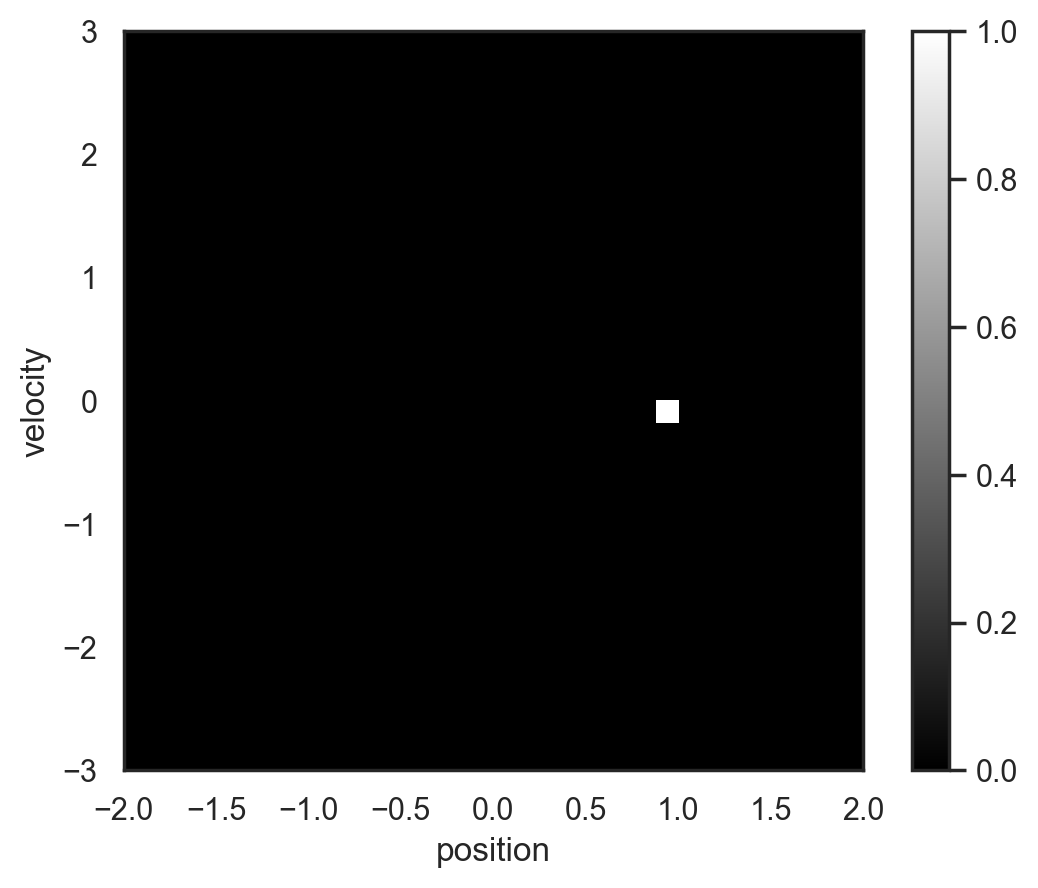

In [106]:
starting_motion = np.array([1., 0.])
dist, idx = tree.query(starting_motion)
idx_act = 0

b = np.zeros(state_space_size)

b[idx] = 1.
plot_belief(b)

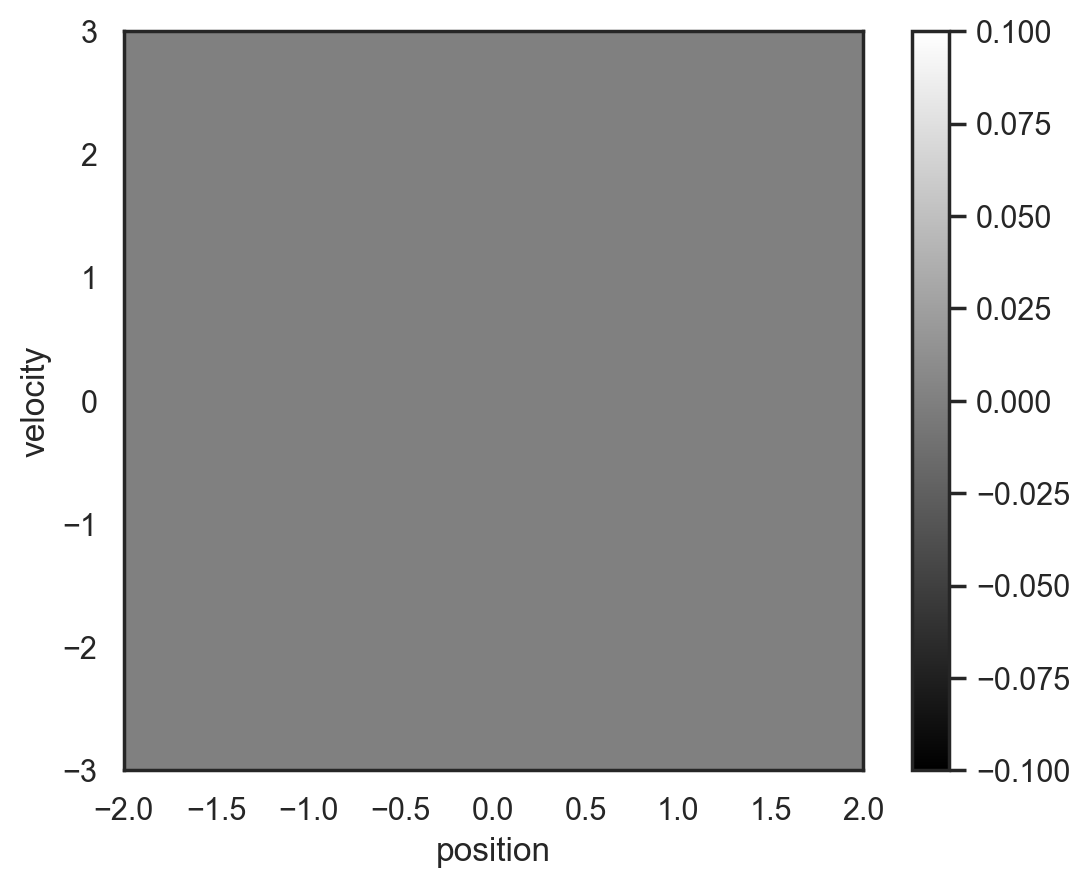

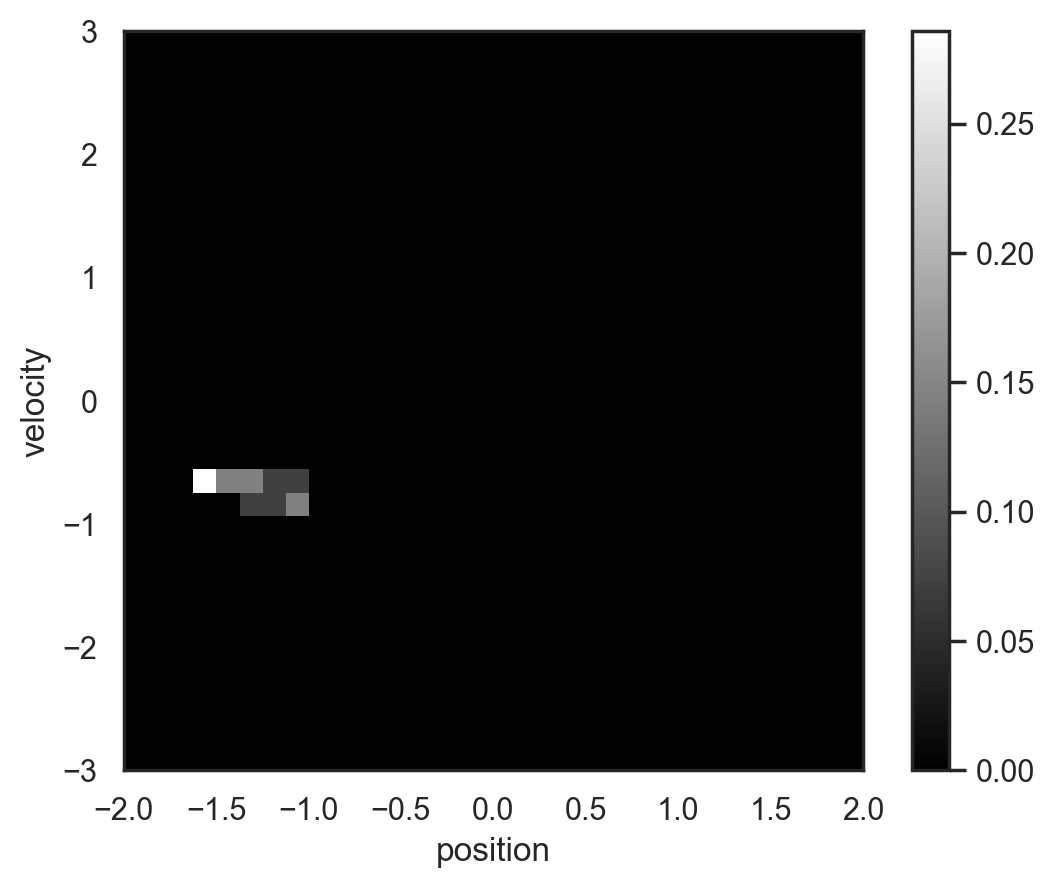

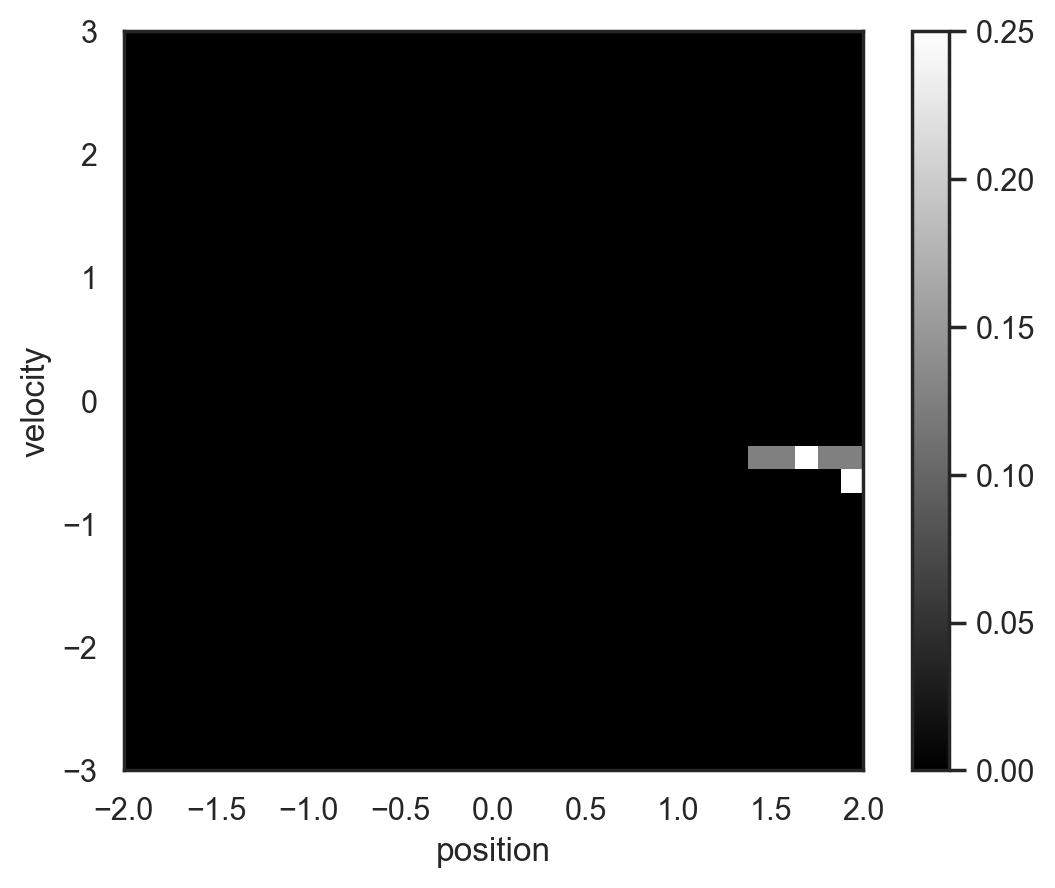

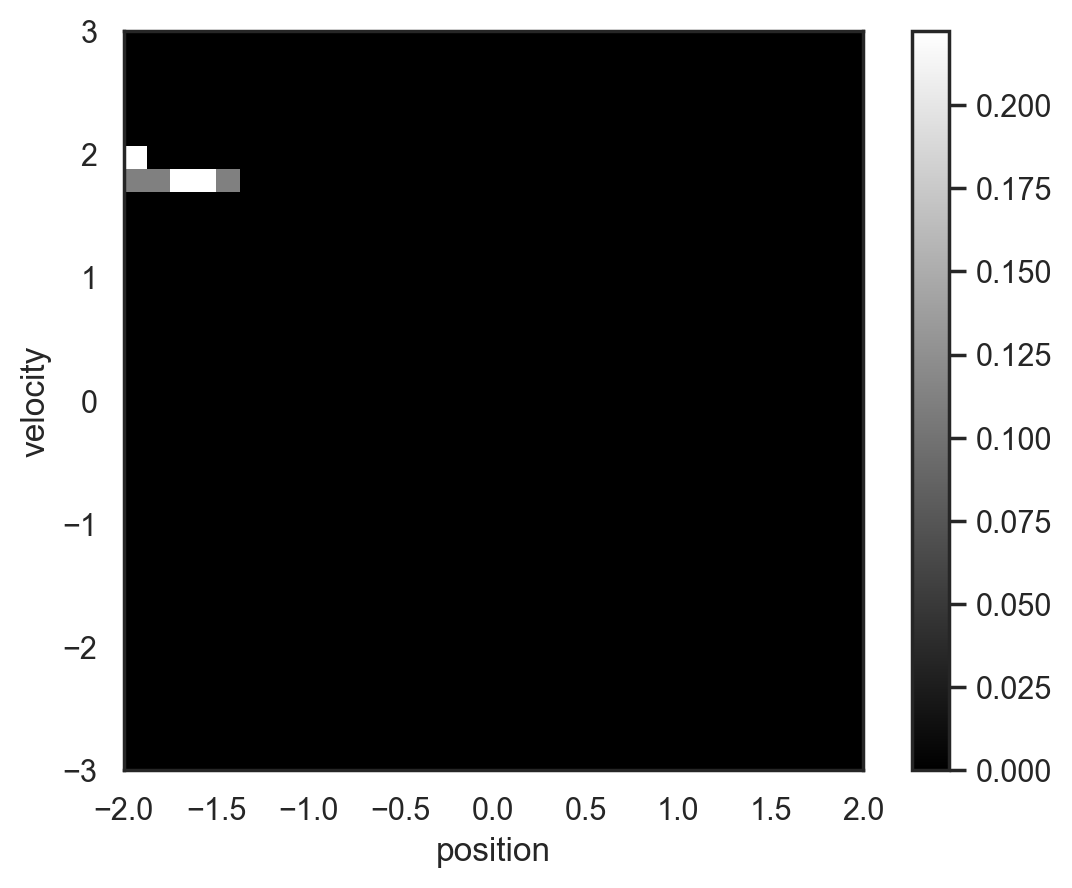

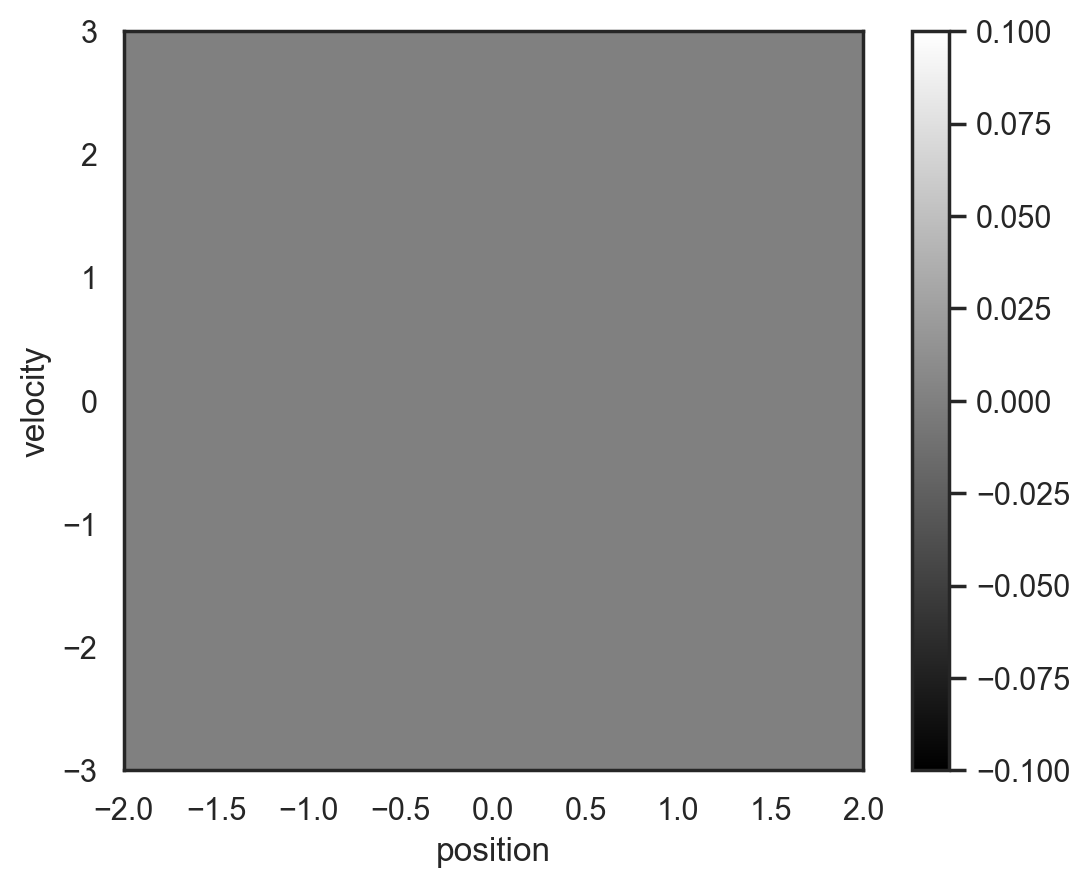

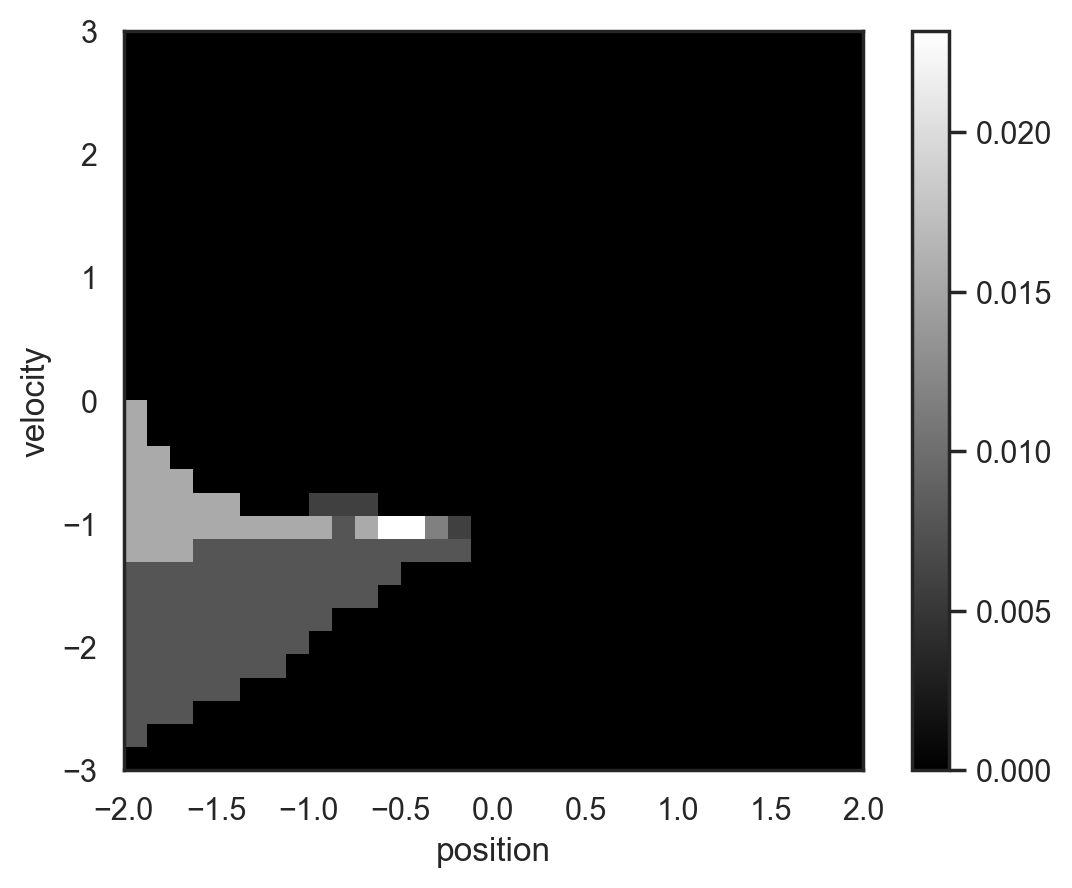

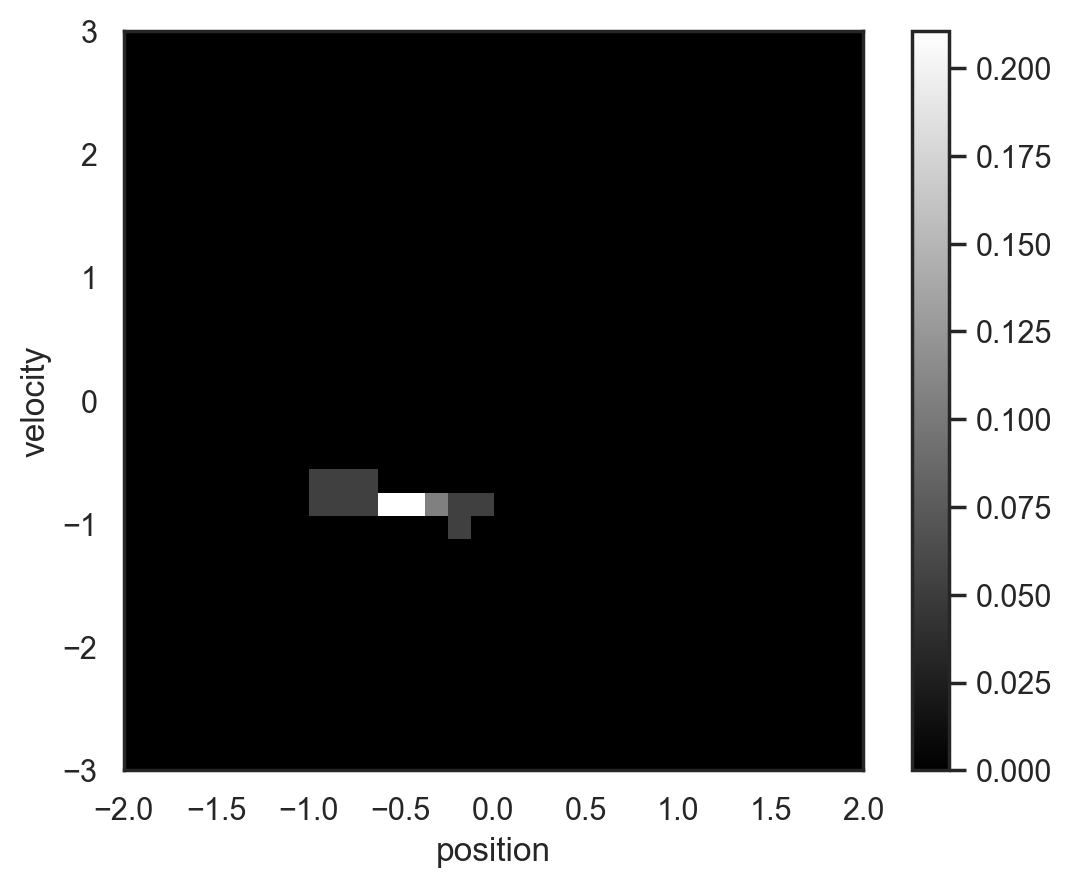

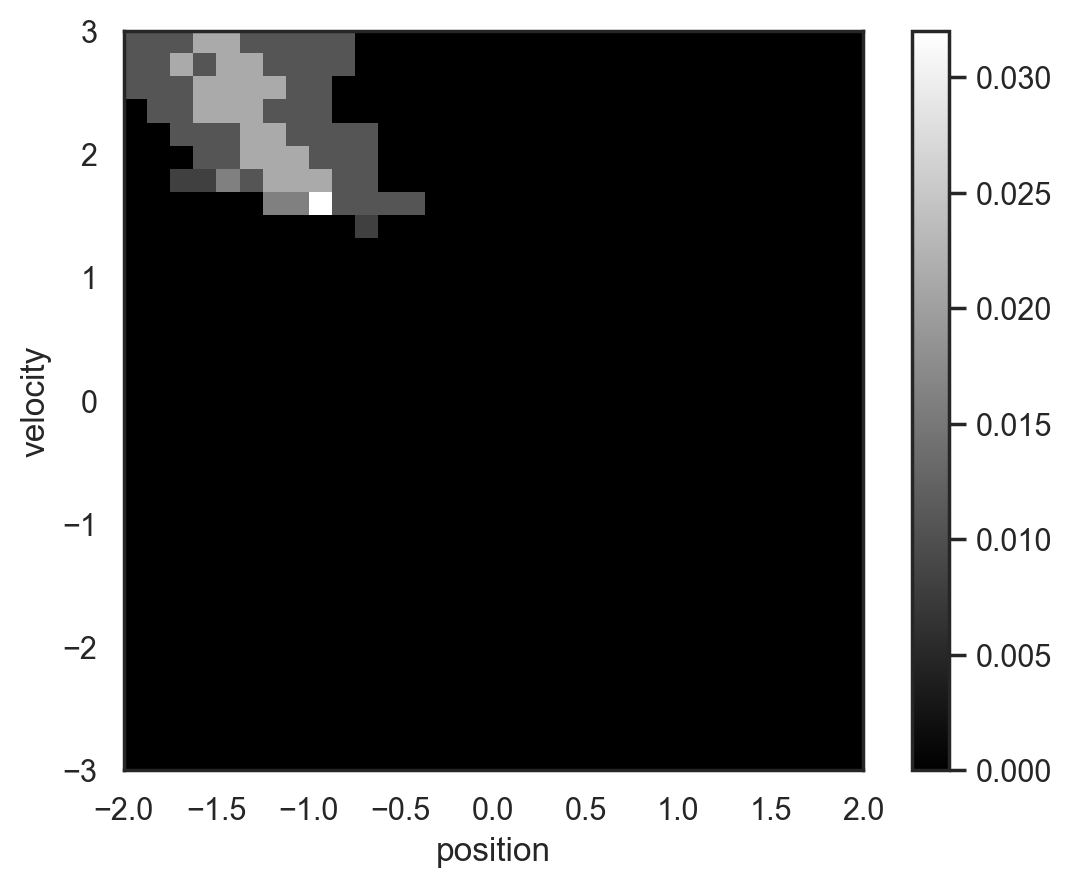

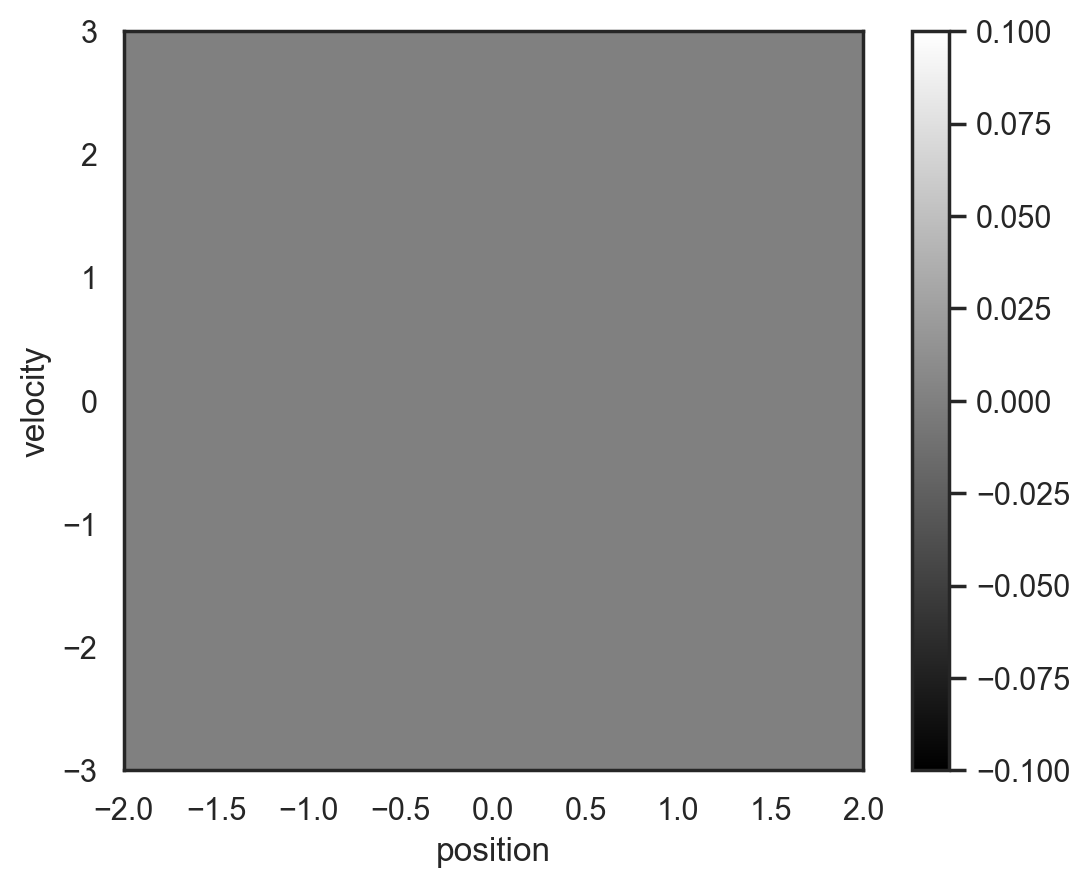

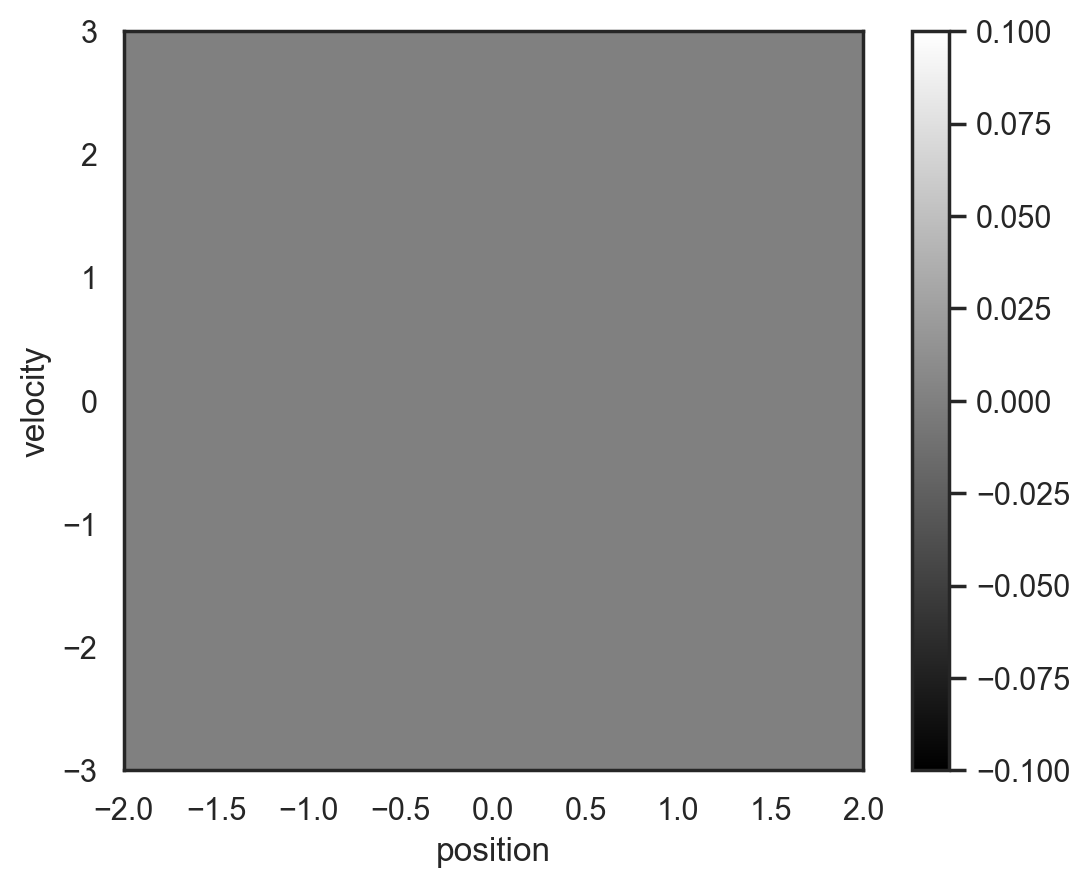

In [107]:
b = np.zeros(state_space_size)
dist, idx = tree.query(starting_motion)
b[idx] = 1

idx_act = np.where(action_space == 0)[0][0]

for idx in np.random.choice(np.arange(state_space_size), size=10):
    plot_belief(p_backward[idx_act, idx, :])

## Getting data

In [108]:
n_steps_variations = [0, 4, 8]

b_plot = np.zeros((len(action_space), len(n_steps_variations), state_space_size))


for idx_act in range(len(action_space)):

    # action = -2
    starting_motion = np.array([1.0, 0.0])

    b = np.zeros(state_space_size)
    dist, idx = tree.query(starting_motion)
    b[idx] = 1
    
    step = 0
    while True:
        if step in n_steps_variations:
            b_plot[idx_act, n_steps_variations.index(step), :] = b
            if step == n_steps_variations[-1]:
                break
        
        new_b = np.zeros_like(b)
        for idx_future in range(state_space_size):
            for idx_past in range(state_space_size):
                new_b[idx_past] += b[idx_future]*p_backward[idx_act, idx_future, idx_past]

        b = new_b
        step += 1

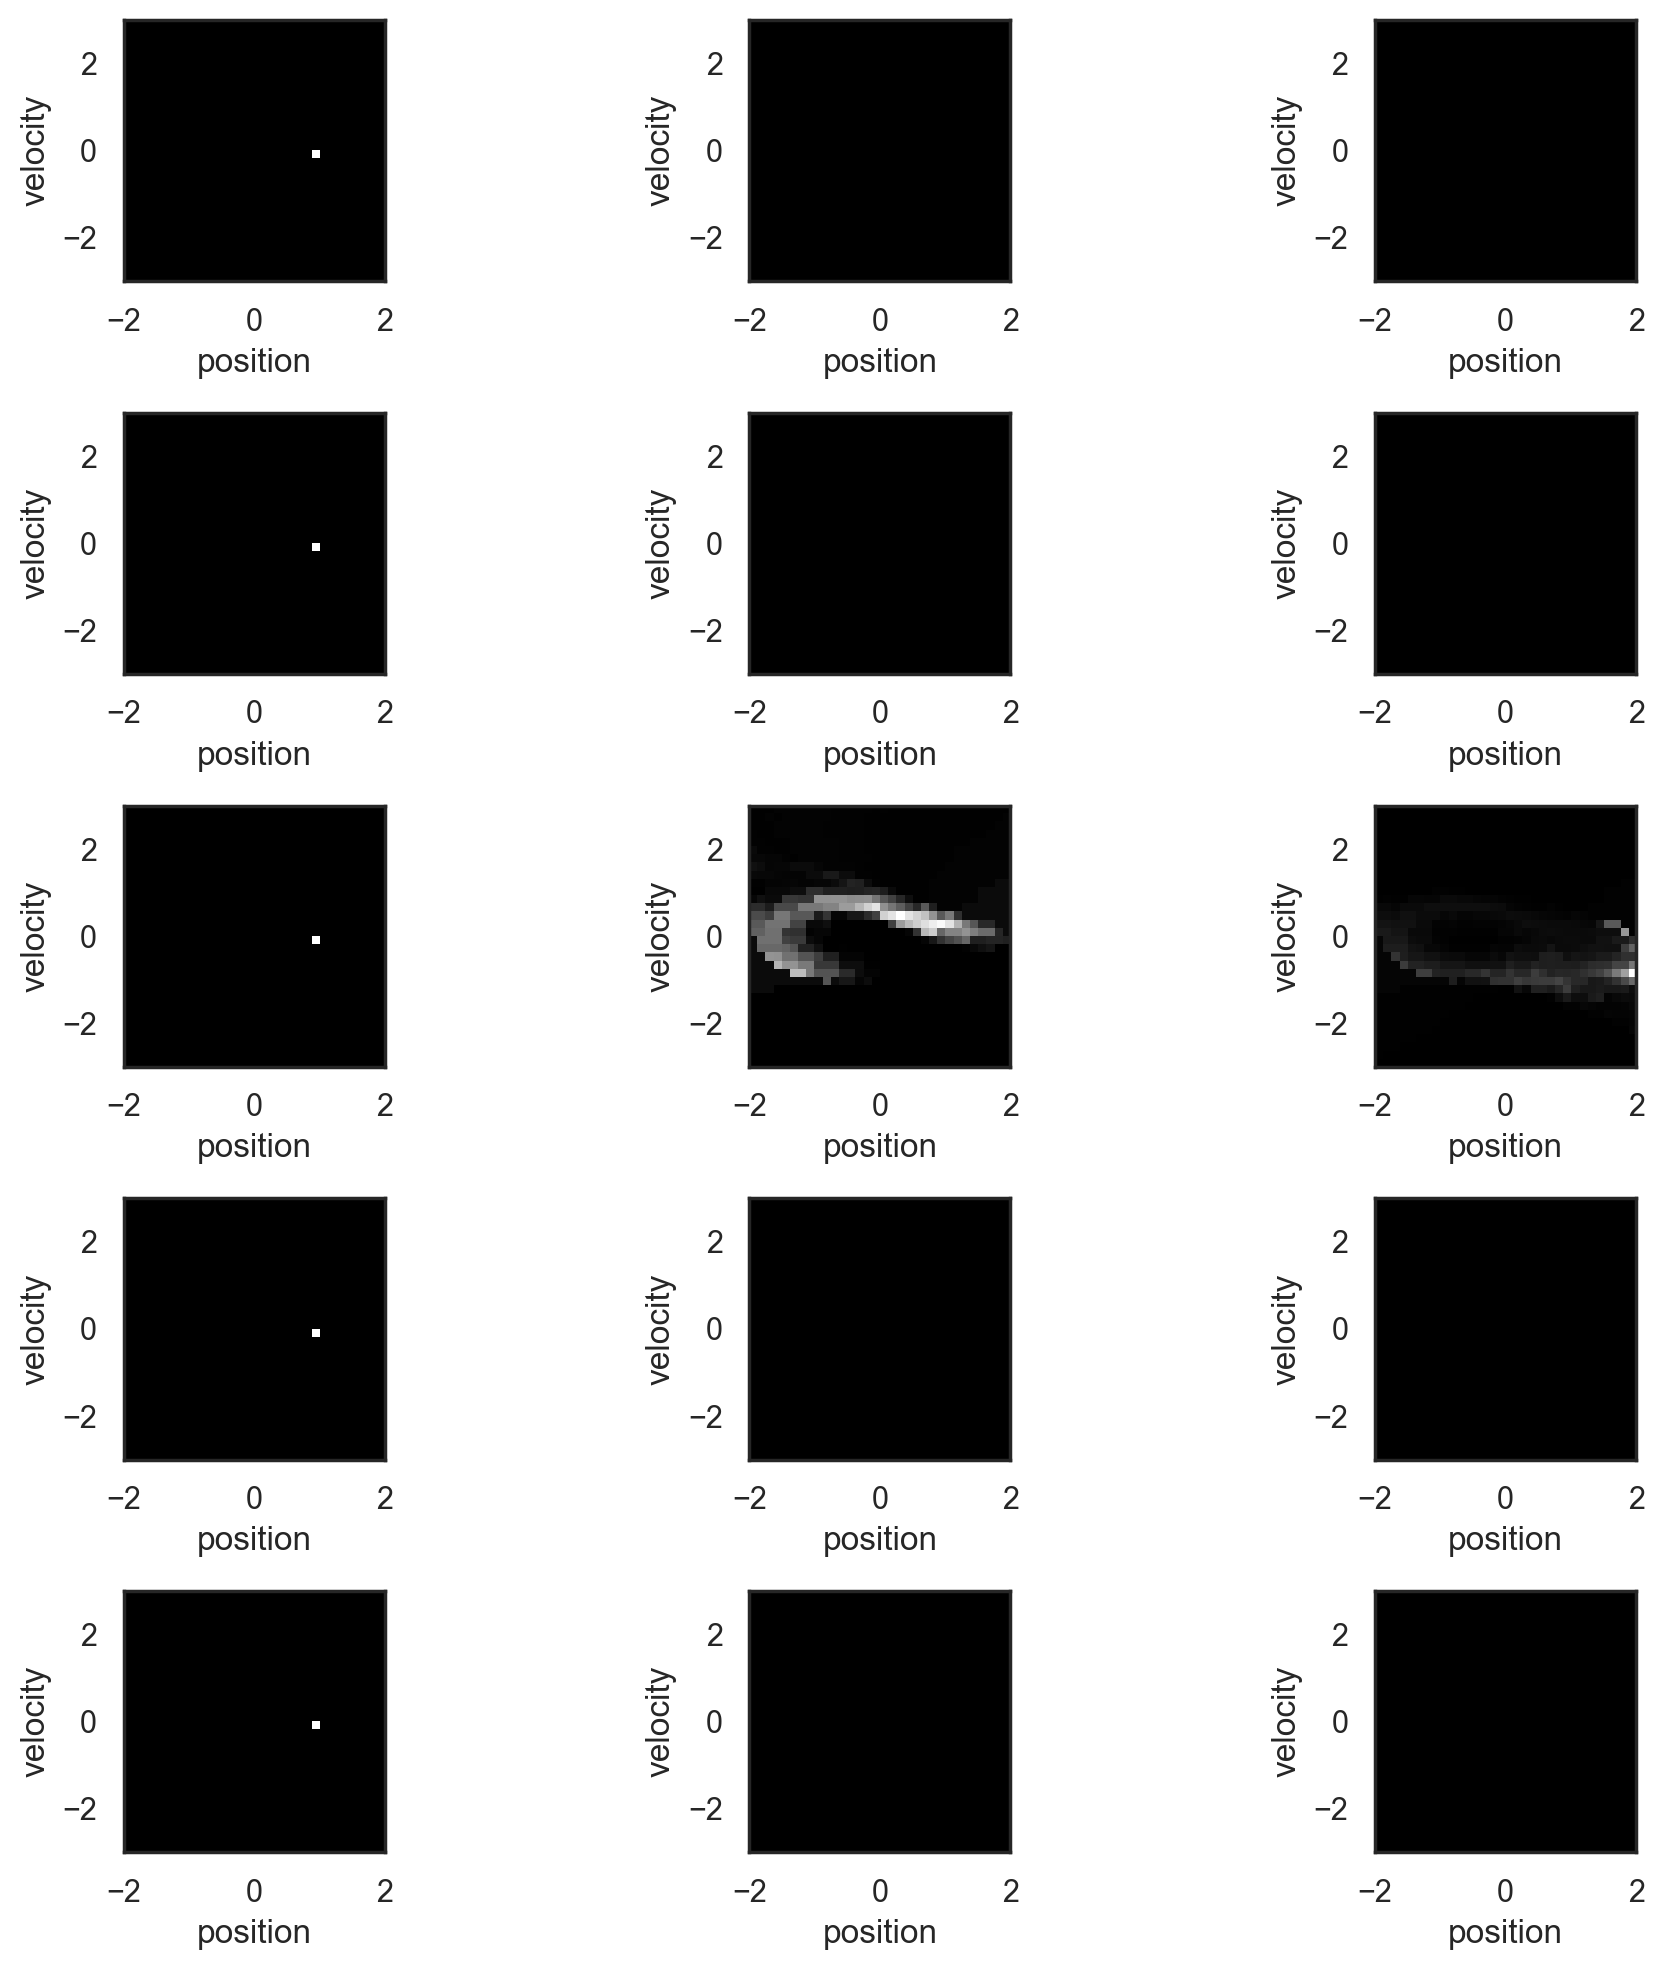

In [109]:
fig, axes = plt.subplots(nrows=len(action_space), ncols=len(n_steps_variations), figsize=(10, 10))

for idx_col, n_steps in enumerate(n_steps_variations):
    for idx_row, action in enumerate(action_space):

    
        plot_belief(b_plot[idx_row, idx_col], 
                    ax=axes[idx_row, idx_col], fig=fig, colorbar=False)

plt.tight_layout()

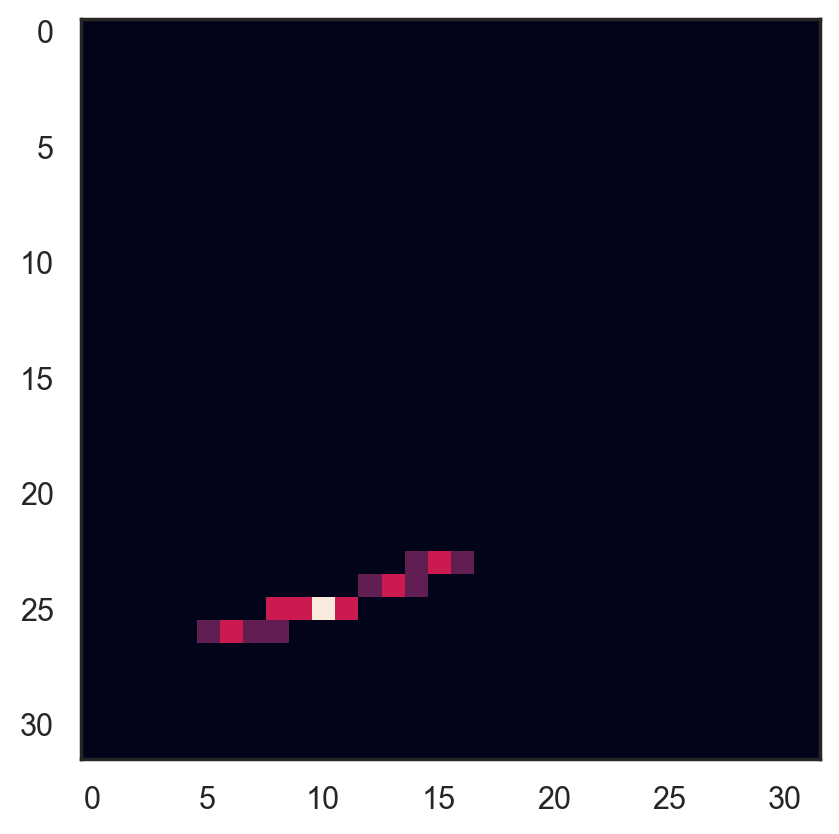

In [110]:
starting_motion = np.array([1.0, 0.0])

b = np.zeros(state_space_size)
dist, idx = tree.query(starting_motion)

plt.imshow(p_backward[1, idx].reshape((len(position_space), -1)));

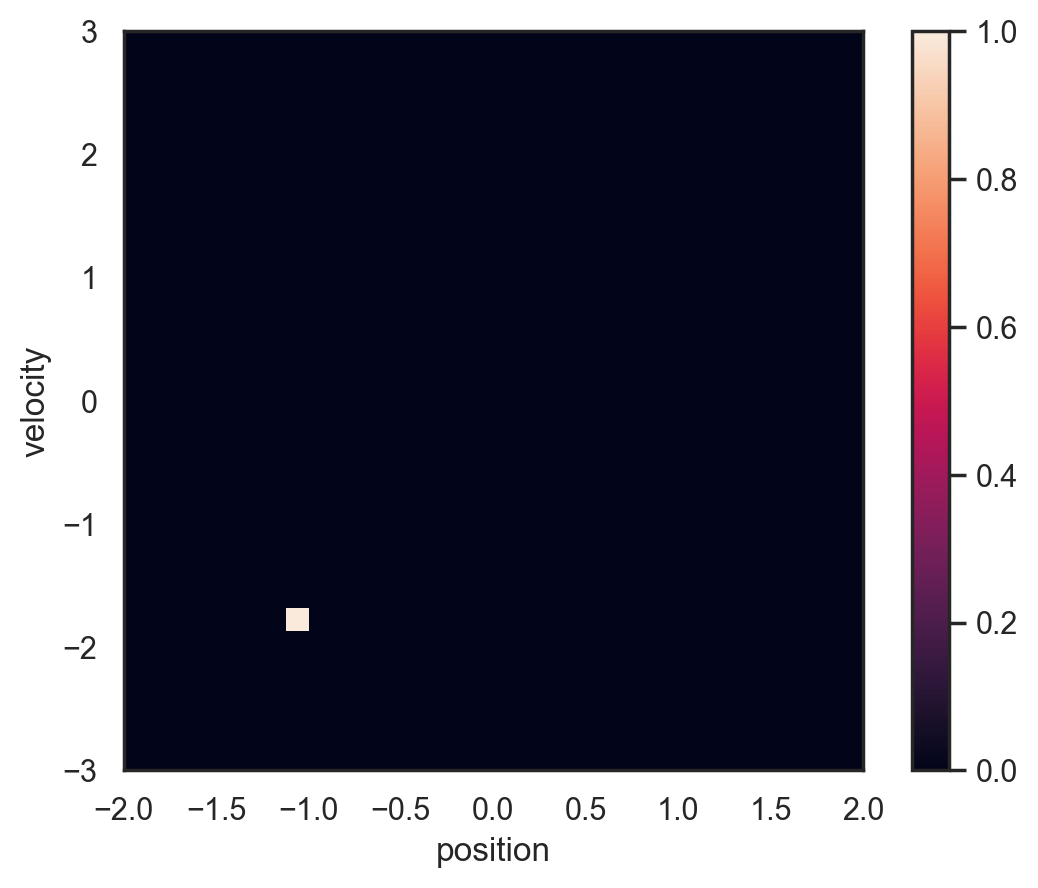

In [58]:
plot_belief(p[0, idx].reshape((len(position_space), -1)));

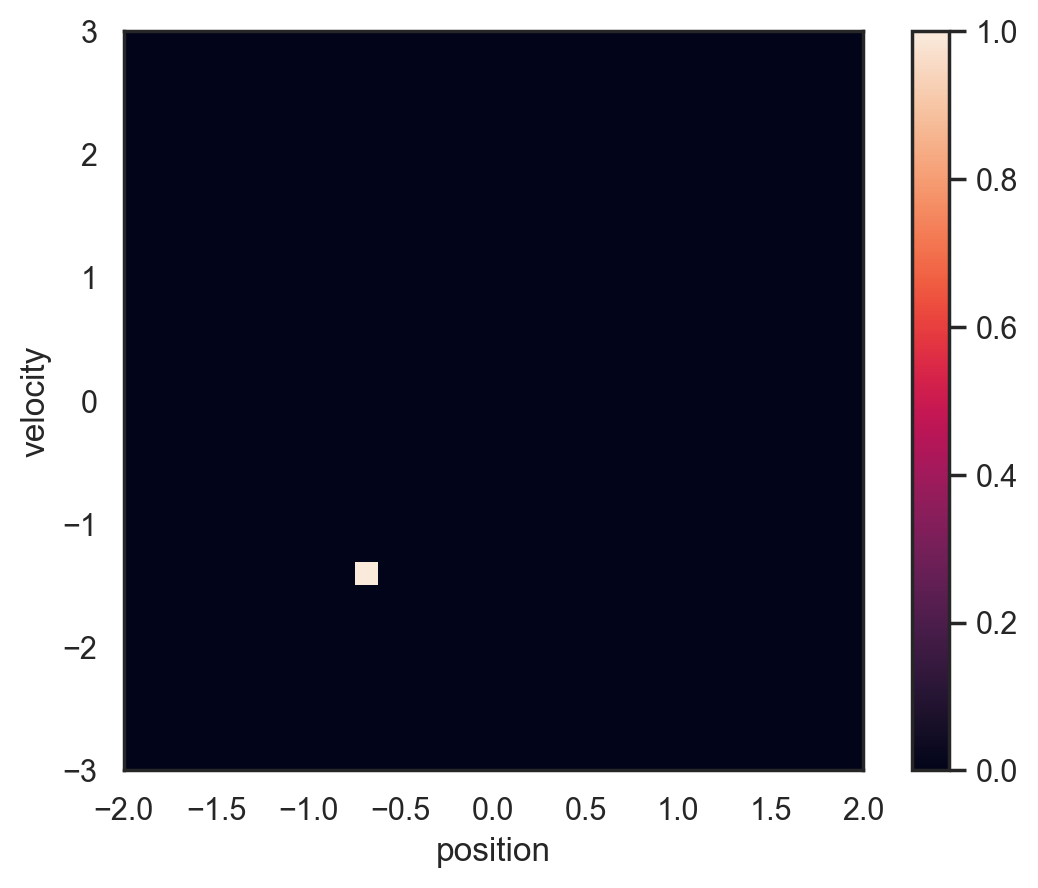

In [59]:
plot_belief(p[1, idx].reshape((len(position_space), -1)));

In [69]:
np.tanh(-2)

-0.9640275800758169

1.0


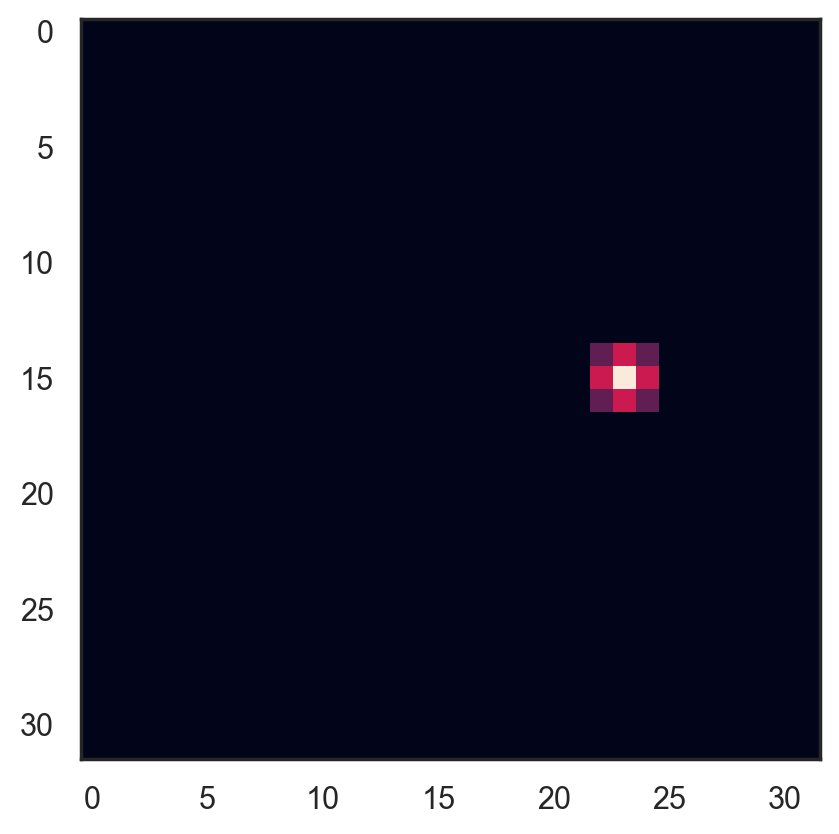

In [102]:
starting_motion = np.array([1.0, 0.0])

b = np.zeros(state_space_size)
dist, idx = tree.query(starting_motion)

s = np.zeros(state_space_size)
s[idx] = 1.

# Do the convolution
s = s.reshape((len(position_space), len(velocity_space)))
s = scipy.signal.convolve(s, kernel, mode="same")
s = scipy.signal.convolve(s, kernel.T, mode="same")
# s = s.ravel()

plt.imshow(s)

print(s.sum())

In [482]:
# def forward_motion(motion, action, delta_t, scale_gravity, scale_friction):
    
#     def _equations_of_motion(t, x, *args):
#         action,  = args
#         position, velocity = x

#         force_action = np.tanh(action)

#         force_friction = -scale_friction * velocity

#         if position <= 0:
#             force_gravity = -2*position - 1
#         else:
#             # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
#             force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3

#         force_gravity *= scale_gravity # Scale it

#         force = force_gravity + force_friction + force_action
#         change_in_velocity = force
#         change_in_position = velocity
        
#         if (velocity >= 3 and change_in_velocity > 0) \
#                 or (velocity <= -3 and change_in_velocity < 0):
#             change_in_velocity = 0
        
#         if (position <= -2 and change_in_position < 0) \
#                 or (position >= 2 and change_in_position > 0):
#             change_in_position = 0
#             change_in_velocity = - velocity # zeroing out velocity
            
#         dy = np.array([change_in_position, change_in_velocity])
#         return dy
    
# #     def _bounds(t, y):
# #         position, velocity = y.reshape((2,))
# #         if position <= -2 or position >=2 or velocity <= -3 or velocity >= 3
# #             return True
# #         else:
# #             return False
    
#     sol = scipy.integrate.solve_ivp(
#         fun=_equations_of_motion, 
#         y0=motion,
#         args=(action, ), 
#         t_span=[0, delta_t, ],
#         t_eval=[delta_t, ])
#         # events=_bounds)
    
#     position, velocity =  sol.y.reshape((2,))
#     position = np.clip(position, -2, 2)
#     velocity = np.clip(velocity, -3, 3)
#     return np.array([position, velocity])

## Debugging

In [545]:
delta_t = 1.
scale_gravity = 0.44
scale_friction = 0.04 # 0.125 # 1/8
scale_action = 0.25
scale_position = 0.5
position_space = np.linspace(-2, 2, 32)
velocity_space = np.linspace(-3, 3, 32)
action_space = np.arange(-2, 3) 
kernel = np.array([1/4, 1/2, 1/4]).reshape((-1,1))

In [546]:
def forward_motion(motion, action, delta_t, 
                   scale_gravity, scale_velocity, scale_action, scale_position):
    
    position, velocity = motion

    force_action = scale_action * np.tanh(action)

    force_friction = -scale_friction * velocity

    if position <= 0:
        force_gravity = -2*position - 1
    else:
        # force_gravity = - position**2*(1+5*position**2)**(-3/2) - (1/8)*position**4
        force_gravity = -(1+5*position**2)**(-3/2) - (1/8)*position**3

    force_gravity *= scale_gravity # Scale it

    force = force_gravity + force_friction + force_action
    change_in_velocity = force
    change_in_position = scale_position*velocity

    if (velocity >= 3 and change_in_velocity > 0) \
            or (velocity <= -3 and change_in_velocity < 0):
        change_in_velocity = 0

    if (position <= -2 and change_in_position < 0) \
            or (position >= 2 and change_in_position > 0):
        change_in_position = 0
        change_in_velocity = - velocity # zeroing out velocity
    
    position += change_in_position
    velocity += change_in_velocity
    
    position = np.clip(position, -2, 2)
    velocity = np.clip(velocity, -3, 3)
    return np.array([position, velocity])

In [547]:
coords = np.dstack(np.meshgrid(position_space, velocity_space)).reshape(-1, 2)
state_space_size = len(position_space) * len(velocity_space)
action_space_size = len(action_space)   

p = np.zeros((action_space_size, state_space_size, state_space_size))

tree = scipy.spatial.KDTree(coords)

for idx_act in range(len(action_space)):
    for idx, coord in enumerate(coords):
        
        act = action_space[idx_act]
        
#         expected_motion = forward_motion(
#             motion=coord,
#             action=act, 
#             delta_t=delta_t,
#             scale_gravity=scale_gravity,
#             scale_velocity=scale_velocity)
        
        expected_motion = forward_motion(
            motion=coord,
            action=act, 
            delta_t=delta_t,
            scale_gravity=scale_gravity,
            scale_velocity=scale_velocity,
            scale_action=scale_action,
            scale_position=scale_position)
        
        dist, idx_closest = tree.query(expected_motion)
        
        s = np.zeros(state_space_size)
        s[idx_closest] = 1.
        
        # Do the convolution
        s = s.reshape((len(position_space), len(velocity_space)))
        s = scipy.signal.convolve(s, kernel, mode="same")
        s = scipy.signal.convolve(s, kernel.T, mode="same")
        s = s.ravel()
        
        p[idx_act, idx, :] =  s
        p[idx_act, idx, :] /= p[idx_act, idx, :].sum()

In [548]:
p_backward = np.zeros_like(p)
for idx_act in range(len(action_space)):
    p_backward[idx_act] = p[idx_act].T
    for idx in range(state_space_size):
        bwd_sum = p_backward[idx_act, idx].sum()
        if bwd_sum > 0:
            p_backward[idx_act, idx] /= bwd_sum # Normalize

In [549]:
n_steps_variations = [0, 4, 8]

b_plot = np.zeros((len(action_space), len(n_steps_variations), state_space_size))


for idx_act in range(len(action_space)):

    # action = -2
    starting_motion = np.array([1.0, 0.0])

    b = np.zeros(state_space_size)
    dist, idx = tree.query(starting_motion)
    b[idx] = 1
    
    step = 0
    while True:
        if step in n_steps_variations:
            b_plot[idx_act, n_steps_variations.index(step), :] = b
            if step == n_steps_variations[-1]:
                break
        
        new_b = np.zeros_like(b)
        for idx_future in range(state_space_size):
            for idx_past in range(state_space_size):
                new_b[idx_past] += b[idx_future]*p_backward[idx_act, idx_future, idx_past]

        b = new_b
        step += 1

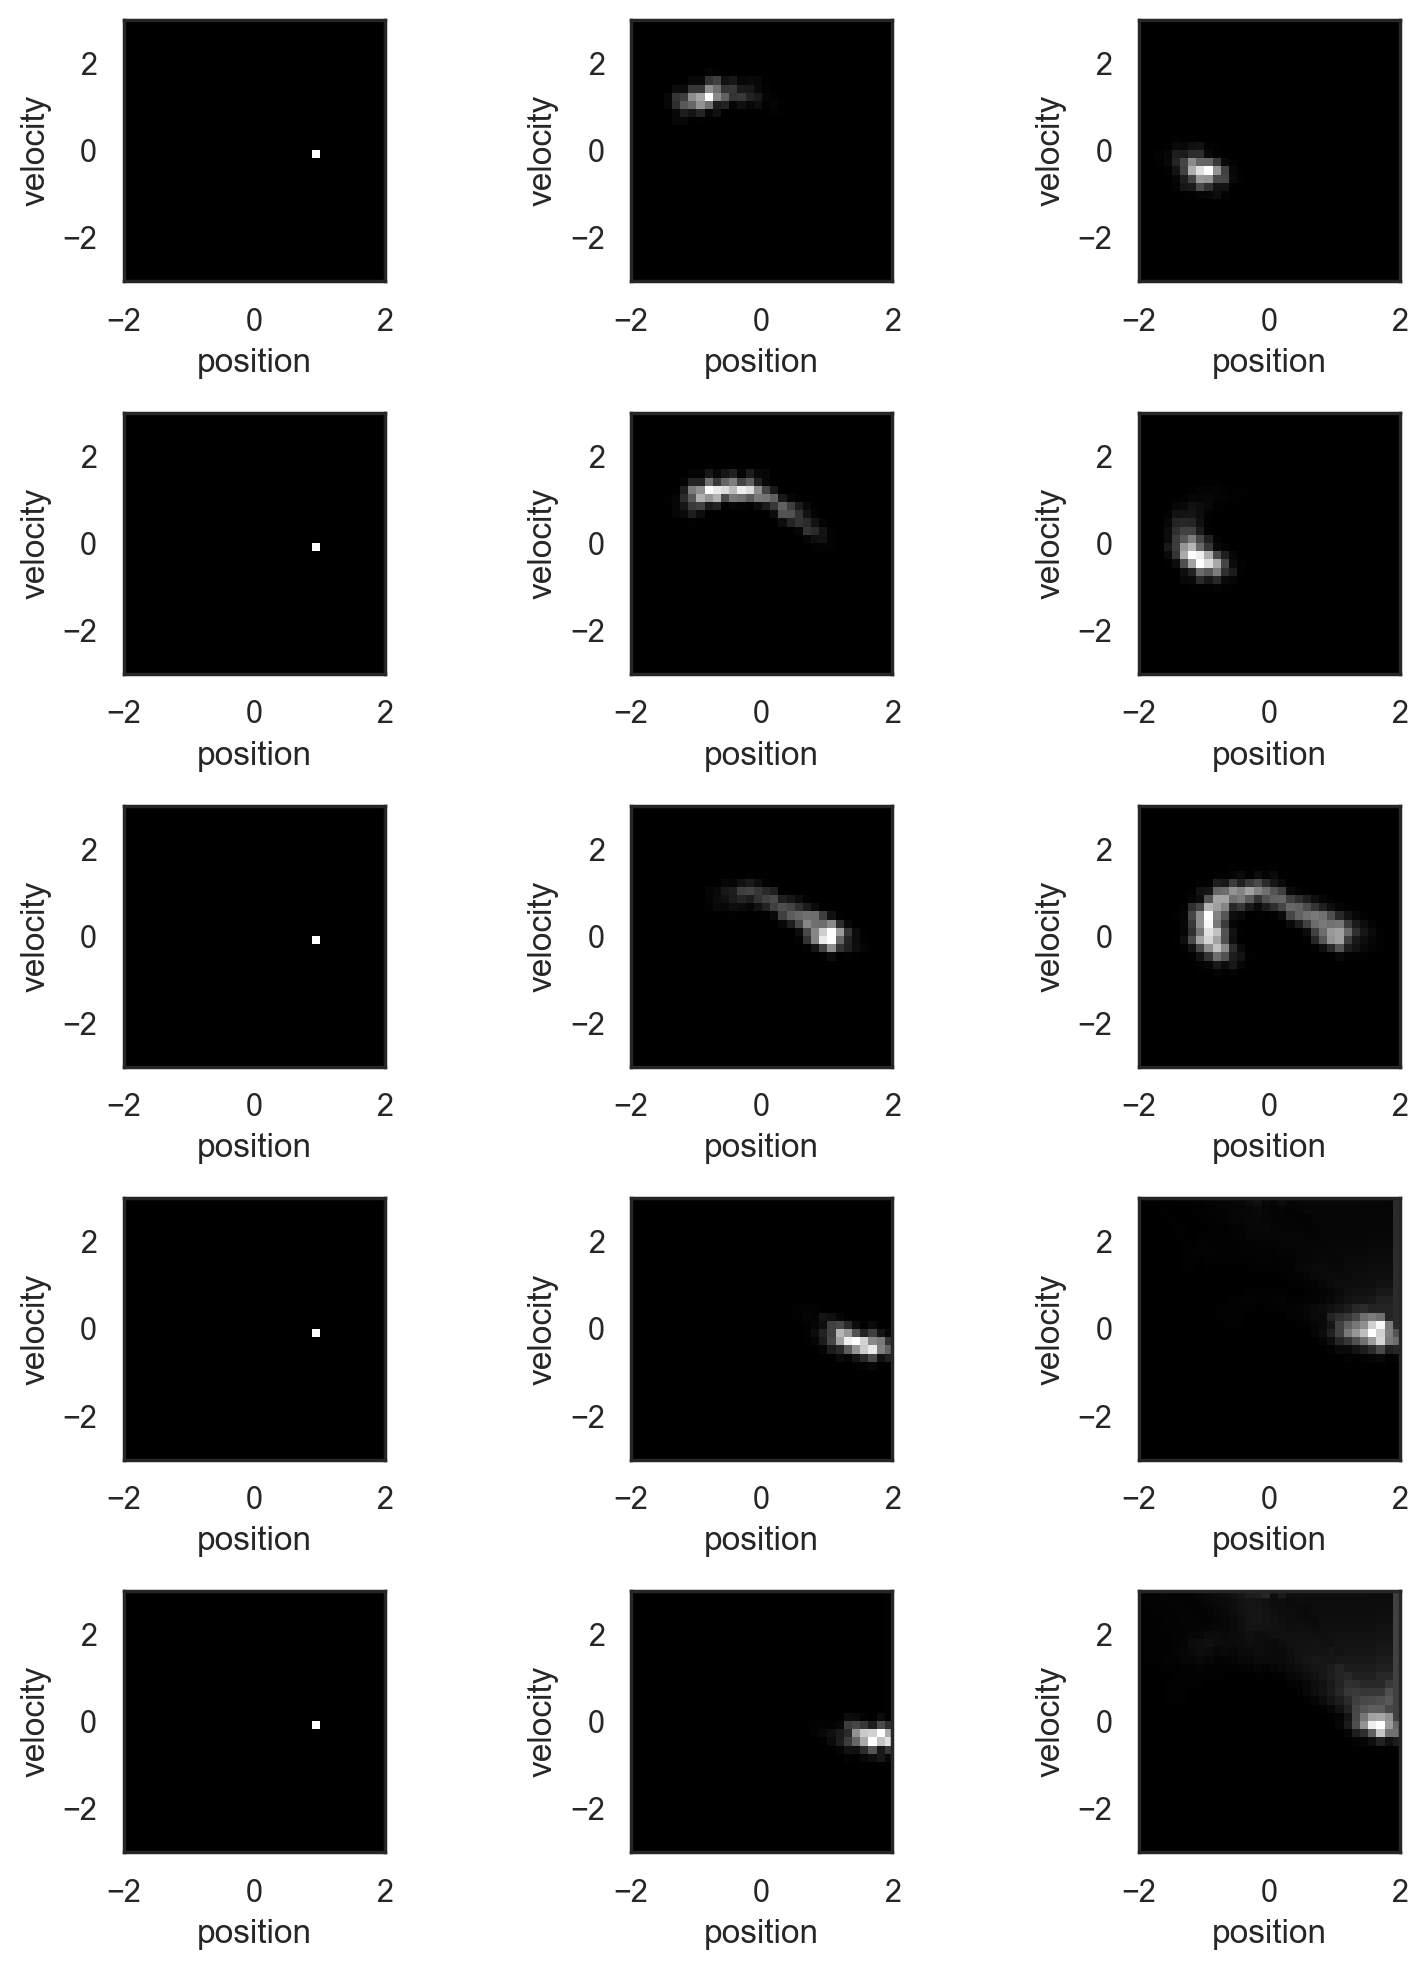

In [553]:
fig, axes = plt.subplots(nrows=len(action_space), ncols=len(n_steps_variations), figsize=(8, 10))

for idx_col, n_steps in enumerate(n_steps_variations):
    for idx_row, action in enumerate(action_space):

        try:
            ax = axes[idx_row, idx_col]
        except IndexError:
            ax = axes[idx_col]
        plot_belief(b_plot[idx_row, idx_col], 
                    ax=ax, fig=fig, colorbar=False)

plt.tight_layout()